## Importación de bibliotecas 

In [1]:
# Entorno de ejecución

# if (firstrun):
if('google.colab' in str(get_ipython() ) ):
    environment= 'google'
else:
    import os
    if (os.environ.get('PWD')=='/kaggle/working'):
        environment= 'kaggle'
    else:
        environment= 'local'
print(environment)

local


## Carga de datos

Si trabajan local
**ESCRIBIR EN SYSTEM PATH EL QUE CORRESPONDA A SUS COMPUTADORAS**

Si trabajan en colab
**ESCRIBIR EN SYSTEM PATH EL QUE CORRESPONDA A SU DRIVE**

In [2]:
# Directorio base ( cambiar según el sistema de archivos de cada uno)
# if (firstrun):
if( environment== 'local' ):
    # system_path = "C:/Users/vanes/Documents/UBA/2do_cuatrimestre/DMCyT/TP/"
    system_path = '/home/vbettachini/documents/universitet/FCEyN/maestríaDatos/cienciaTecnología/'
elif( ( environment== 'google' ) ): 
    from google.colab import drive
    drive.mount('/content/drive')
    system_path = "/content/drive/MyDrive/maestría/cienciaTecnología/"
elif( ( environment== 'kaggle' ) )  :
    a= 1

# Directorio del dataset
dataset_path = system_path + "tp1_dmcyt2023/datasets/Rice_Image_Dataset"

In [3]:
# Path a subset imágenes generado por `random_sample_rice_images.ipynb`
image_path = dataset_path + "/random_sample_rice_images"

In [4]:
import numpy as np

In [5]:
data = np.load(image_path + '/vgg16output.npz')
data.files

['feat', 'names']

In [6]:
names = data['names']
feat = data['feat']

## PCA

In [7]:
import pandas as pd

In [8]:
# get the unique labels (from the flower_labels.csv)
df = pd.read_csv(image_path + '/random_sample_rice_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))

In [9]:
# if (firstrun):
try:
  # clustering and dimension reduction
  from sklearn.decomposition import PCA
except:
  ! pip install scikit-learn
  from sklearn.decomposition import PCA

In [10]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [11]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 100


In [12]:
# size of variable feat in GB
from sys import getsizeof
print(f"Size of variable feat in GB: {getsizeof(feat)/1024/1024/1024}")


Size of variable feat in GB: 0.07629406452178955


## K-means

In [13]:
from sklearn.cluster import KMeans

In [14]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=3)
kmeans.fit(x)

/home/vbettachini/bin/jupyter/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

### Visualización de imágenes en cada cluster

In [15]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [24]:
# function that lets you view a cluster (based on identifier)
def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster))
        plt.axis('off')

In [26]:
import matplotlib.pyplot as plt

In [29]:
from tensorflow.keras.preprocessing.image import load_img

2023-09-27 15:52:19.100038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 15:52:29.221769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Clipping cluster size from 1780 to 10


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/maestría/cienciaTecnología/tp1_dmcyt2023/datasets/Rice_Image_Dataset/random_sample_rice_images/Arborio (1135).jpg'

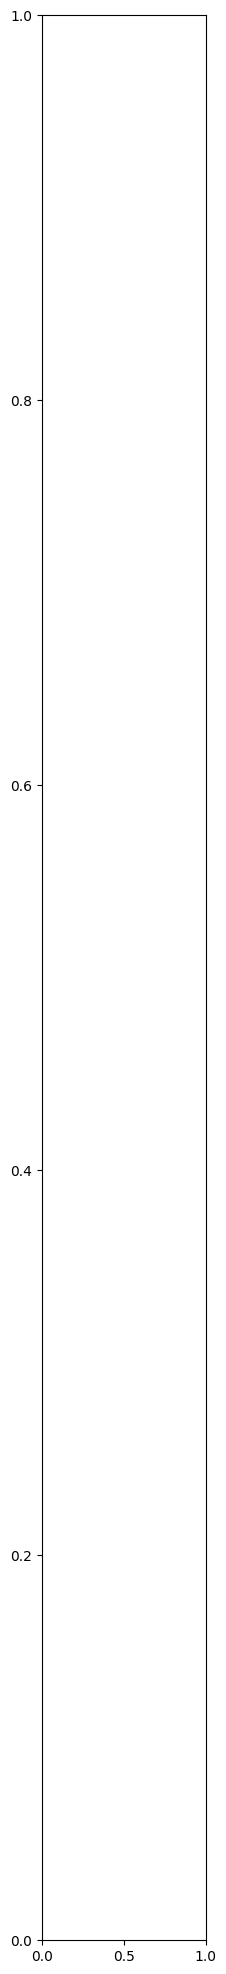

In [30]:
# display images for each cluster
for n in range(len(groups)):
  view_cluster(groups[n],n)

In [32]:
names

array(['/content/drive/MyDrive/maestría/cienciaTecnología/tp1_dmcyt2023/datasets/Rice_Image_Dataset/random_sample_rice_images/Arborio (1002).jpg',
       '/content/drive/MyDrive/maestría/cienciaTecnología/tp1_dmcyt2023/datasets/Rice_Image_Dataset/random_sample_rice_images/Arborio (10075).jpg',
       '/content/drive/MyDrive/maestría/cienciaTecnología/tp1_dmcyt2023/datasets/Rice_Image_Dataset/random_sample_rice_images/Arborio (10088).jpg',
       ...,
       '/content/drive/MyDrive/maestría/cienciaTecnología/tp1_dmcyt2023/datasets/Rice_Image_Dataset/random_sample_rice_images/basmati (9956).jpg',
       '/content/drive/MyDrive/maestría/cienciaTecnología/tp1_dmcyt2023/datasets/Rice_Image_Dataset/random_sample_rice_images/basmati (9963).jpg',
       '/content/drive/MyDrive/maestría/cienciaTecnología/tp1_dmcyt2023/datasets/Rice_Image_Dataset/random_sample_rice_images/basmati (9984).jpg'],
      dtype='<U140')